In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neural_network import MLPClassifier

In [3]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np

def test_library():
  print('Testing the library')

def take_photo(filename='webcam.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return binary,filename

def grab_from_webcam(filename):
  try:
    binary, filename = take_photo(filename)
  except Exception as err:
    print(str(err)) 

def get_webcam(filename = 'webcam.jpg'):
  grab_from_webcam(filename)
  im = plt.imread(filename)
  return im

def load_quickdraw(filename):
  return 255 - np.load(filename)

def get_quickdraw(filename,shape=(-1,28)):
  data = load_quickdraw(filename)
  dims = (len(data[:,0]),shape[0],shape[1])
  return np.reshape(data,dims)

def show_image(im):
  if (len(im.shape)==2):
      plt.imshow(im,cmap='gray')
  else:
    plt.imshow(im)

def convert_to_grayscale(im):
    rgb_weights = [0.2989, 0.5870, 0.1140]
    return np.dot(im, rgb_weights).astype(int)

def convert_to_color(im):
  im_new = np.array([im,im,im])
  im_new = np.swapaxes(im_new,0,2)
  im_new = np.swapaxes(im_new,0,1)
  return im_new
  
def convert_to_rectangular(im):
  dims = im.shape
  if (np.argmax(dims) == 1):
    start = (dims[1] - dims[0])//2
    if (len(dims) == 3):
      im_rect = im[:,start:start+dims[0],:] 
    else:
      im_rect = im[:,start:start+dims[0]]
  else:
    start = (dims[0] - dims[1])//2
    if (len(dims) == 3):
      im_rect = im[start:start+dims[1],:,:] 
    else:
      im_rect = im[start:start+dims[1],:]
  return im_rect

def convert_to_bw(im,threshold=128):
    dims = im.shape
    if (len(dims) == 3):
      im = convert_to_grayscale(im)
    im_bw = (im>threshold)*255
    return im_bw

def shrink(im,size=(28,28)):
  dims = im.shape
  if (len(dims) == 3):
    return resize(im,(size[0],size[1],dims[2]),preserve_range=True,anti_aliasing=True).astype(int)
  else:
    return resize(im,size,preserve_range=True,anti_aliasing=True).astype(int)

def convert_to_sketch(im,threshold=128,size=(28,28),bw=False):

  im_rect = convert_to_rectangular(im)

  if (len(im.shape)==3):
    im_gray = convert_to_grayscale(im_rect)
  else:
    im_gray = im_rect

  im_bw = convert_to_bw(im_gray,threshold)

  im_scaled = shrink(im_bw,size)

  if (bw):
    threshold2 = 210
    return ((im_scaled>threshold2)*255).astype(int)
  else:
    return im_scaled

In [4]:
banana_full = get_quickdraw("/content/full_numpy_bitmap_banana.npy")
broom_full =  get_quickdraw("/content/full_numpy_bitmap_broom.npy")

banana_full = banana_full[range(0, 30000), :, :]
broom_full = broom_full[range(0, 30000), :, :]

banana_full = banana_full.reshape(30000, -1)
broom_full = broom_full.reshape(30000, -1)

In [5]:
zeros = np.zeros((30000, 1))
ones = np.ones((30000, 1))

labels = np.concatenate((ones, zeros))

full_data = np.concatenate((banana_full, broom_full))

full_data = np.concatenate((labels, full_data), axis = 1)

In [6]:
y = full_data[:, 0]
X = full_data[:, range(1, 785)]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

In [8]:
model = MLPClassifier(hidden_layer_sizes = (10, 10, 10, 10), max_iter = 10000)

model.fit(X_train, y_train)
score_train = model.score(X_train, y_train)
print (score_train)

0.9552291666666667


In [9]:
y_test_predict = model.predict(X_test)
score_test = model.score(X_test, y_test)
print (score_test)

0.9505


In [10]:
from joblib import dump, load
import gdown

import google drive file here:https://drive.google.com/file/d/1zw5fopSBL8Em8wehipbYRvkSCvuvg98f/view?usp=sharing
type file name (with .jpg or .png):banana.jpg
This is a banana? type, "yes" or "no"yes
:)
do you want to input another file? type "yes" or "no"no


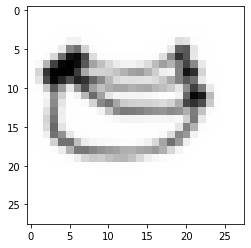

In [14]:
v = 0

while v < 100:
  image_file = str(input('import google drive file here:'))
  image_file = image_file.replace('https://drive.google.com/file/d/', "")
  image_file = image_file.replace('/view?usp=sharing', "")
  output = str(input('type file name (with .jpg or .png):'))

  gdown.download(id=image_file, output=output, quiet = True)

  image = plt.imread(f"{output}") 
  image = convert_to_sketch(image, threshold = 100)
  plt.imshow(image, cmap = 'gray')

  image = image.reshape(1, -1)

  image_predict = model.predict(image)
  if image_predict[0] == 1: #if banana
    is_banana = str(input('This is a banana? type, "yes" or "no"'))
    if is_banana == "yes":
      print(":)")
    else:
      print("Sorry, it must be a broom")
  else: #if broom
    is_broom = str(input('This a broom? type, "yes" or "no"'))
    if is_broom == "yes":
      print(":)")
    else:
      print("Sorry, it must be a banana")

  function_continue = str(input('do you want to input another file? type "yes" or "no"'))
  if function_continue == "yes":
    v += 1
  else:
    v = 101